Author: Amiri Hayes \
Date Updated: 7/2/25 \
Title: ViewLLM

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import spacy
nlp = spacy.load("en_core_web_sm")
from transformers import AutoTokenizer, AutoModel

In [ ]:
# BASIC POSITIONAL FILTERING PATTERNS

def next_attention(sentence, tokenizer):
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    
    out = np.zeros((len_seq, len_seq))
    for i in range(1, len_seq-1):
        out[i, i+1] = 1
    out[0,0] = 1
    out[-1,0] = 1
    return "Next Head Attention Pattern", out

def previous_attention(sentence, tokenizer):
    return "", 0

def same_attention(sentence, tokenizer):
    return "", 0

def punctuation_attention(sentence, tokenizer):
    return "", 0

def repeated_attention(sentence, tokenizer):
    return "", 0

# LINGUISTIC ROLE ALIGNMENT PATTERNS

def dependencies(sentence, tokenizer):
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    words = sentence.split()
    doc = nlp(" ".join(words))
    # if len(doc) == 0: print("problem, doc empty")
    # if len(doc) != (len_seq-2): print("problem, doc length mismatch", len(doc), len(toks)-2)
    for stok in doc:
        parent_index = stok.i
        for child_stok in stok.children:
            child_index = child_stok.i
            out[parent_index+1, child_index+1] = 1
            out[child_index+1, parent_index+1] = 1
    out[0, 0] = 1
    out[-1, 0] = 1
    out += 1e-4
    out = out / out.sum(axis=1, keepdims=True)
    return "Dependency Parsing Pattern", out

In [144]:
def score_prediction(sentence, torch_model, torch_tokenizer, head_loc, pattern, output=False):
    layer, head = head_loc
    tokens = torch_tokenizer(sentence, return_tensors="pt")

    att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()
    name, pred_att = pattern(sentence, torch_tokenizer)

    score = np.abs(att - pred_att).sum()

    if output:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        im1 = axes[0].imshow(att, cmap="viridis", aspect='auto')
        axes[0].set_title("Actual Head Attention")
        fig.colorbar(im1, ax=axes[0])

        im2 = axes[1].imshow(pred_att, cmap="viridis", aspect='auto')
        axes[1].set_title("Optimal Head Attention")
        fig.colorbar(im2, ax=axes[1])

        fig.suptitle(f"Results for {name} @ L{layer},H{head}\n\nRaw Score = {score:.2f}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return score

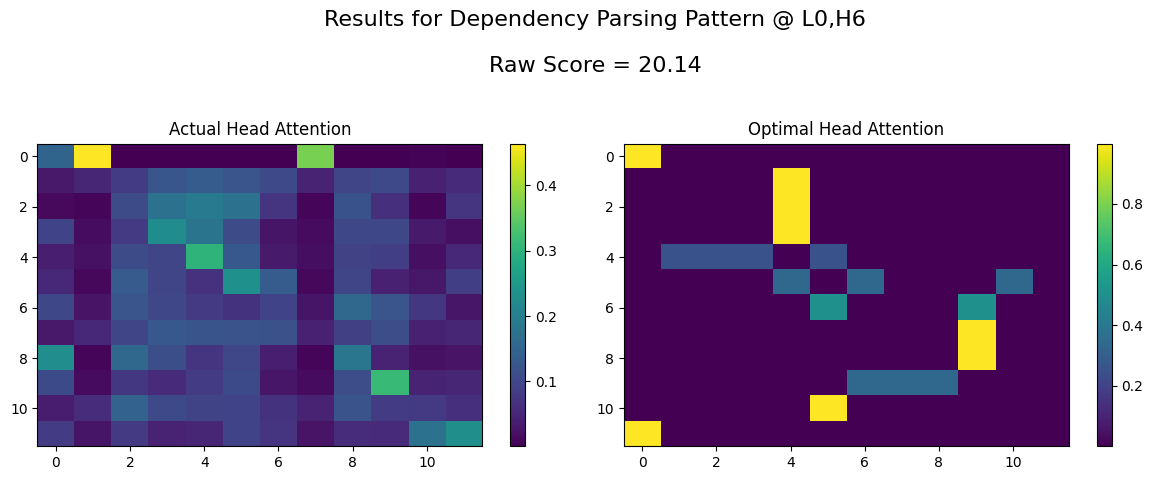

np.float64(20.138757607269923)

In [179]:
sentence = "The quick brown fox jumps over the lazy dog."
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)
model.eval()
layer, head = 0, 6

score_prediction(sentence, model, tokenizer, (layer, head), dependencies, output=True)

problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc length mismatch 10 1
problem, doc l

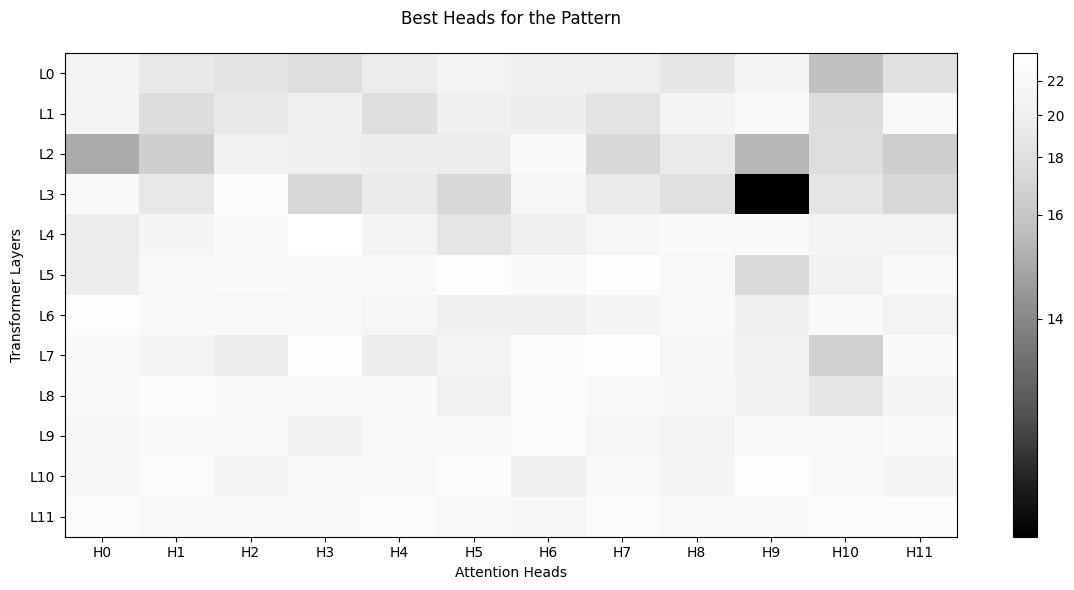

array([[20.77977172, 19.07429749, 18.55081555, 17.91178004, 19.48894851,
        20.72441408, 20.13875761, 20.01768963, 18.84985149, 21.1745801 ,
        15.66933425, 18.20164762],
       [20.94338463, 17.73286798, 19.11640893, 20.26956846, 17.87767424,
        20.2562556 , 19.83865374, 18.54512952, 21.03654935, 21.98042755,
        17.76243289, 21.9832567 ],
       [14.87059672, 16.616736  , 20.43806796, 20.14981215, 19.81391068,
        19.51385724, 22.65302603, 17.30454595, 19.25065263, 15.250852  ,
        17.9220898 , 16.49691291],
       [22.5944565 , 19.10877789, 22.75063573, 17.24261161, 19.36308962,
        17.28944415, 21.91639959, 19.26329693, 18.14647537, 13.25253297,
        18.69659963, 17.18594324],
       [19.56352223, 21.36297873, 22.6374871 , 23.9066811 , 20.90678618,
        18.67879261, 20.2383202 , 21.42759454, 22.46229769, 22.38824532,
        20.93684899, 20.92392575],
       [19.50824543, 21.98632017, 22.68598451, 22.30742019, 22.4233573 ,
        23.48723239, 2

In [177]:
from matplotlib.colors import PowerNorm
def visualize_full_model(sentence, torch_model, torch_tokenizer, pattern, bias_towards_best=0.9):
    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads
    model_viz = np.zeros((num_layers, num_heads))
    
    for i in range(num_layers):
        for j in range(num_heads):
            score = score_prediction(sentence, torch_model, torch_tokenizer, (i, j), pattern)
            model_viz[i, j] = score
    
    plt.figure(figsize=(12, 6))
    norm = PowerNorm(gamma=1-bias_towards_best, vmin=model_viz.min(), vmax=model_viz.max())
    plt.imshow(model_viz, cmap='Greys_r', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title("Best Heads for the Pattern\n")
    plt.xlabel("Attention Heads")
    plt.ylabel("Transformer Layers")
    plt.xticks(ticks=np.arange(num_heads), labels=[f'H{h}' for h in range(num_heads)])
    plt.yticks(ticks=np.arange(num_layers), labels=[f'L{l}' for l in range(num_layers)])
    plt.tight_layout()
    plt.show()
    return model_viz

visualize_full_model(sentence, model, tokenizer, dependencies, bias_towards_best=0.7)

In [70]:
from collections import Counter
def repeated_attention(sentence, model, tokenizer, head, layer, output=False):
    
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad(): outputs = model(**inputs)
    attention = outputs.attentions[layer] 

    attn_matrix = attention[0, head]
    seq_len = attn_matrix.shape[0]
    
    if output:
        for i, row in enumerate(attn_matrix):
            probs = []
            for val in row: probs.append(f"{val.item():.2f}")
            print(f"Token {i}: {probs}")

    token_counts = Counter(sentence.split())
    print(f"Token counts: {token_counts}")
    repeated_tokens = {tok for tok, count in token_counts.items() if count > 1}

    if not repeated_tokens:
        return 0
    
    repeated_indices = [i for i, tok in enumerate(inputs) if tok in repeated_tokens]

    for i in repeated_indices:
        attn_to_repeats = sum(attn_matrix[i][j] for j in repeated_indices)
        if attn_to_repeats > 0.5:
            if output: print(f"Same token pattern detected")
            return 1  
        
    if output: print(f"No repeated attention pattern detected")
    return 0